In [1]:
%%sql
SELECT * from checkpoints

,thread_id,checkpoint_ns,checkpoint_id,parent_checkpoint_id,type,checkpoint,metadata
0,1,NaN,1f04aa53-28d9-6604-bfff-8c5395f80bed,NaN,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""input"", ""writes"": {""__start__"": {""..."
1,1,NaN,1f04aa53-28db-6c10-8000-95cc2c884983,1f04aa53-28d9-6604-bfff-8c5395f80bed,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": null, ""step"": 0, ..."
2,1,NaN,1f04aa53-50b9-6fde-8001-746bf1772055,1f04aa53-28db-6c10-8000-95cc2c884983,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": {""conversation"": ..."
3,1,NaN,1f04aa53-5103-6bca-8002-8ee4d05df4ea,1f04aa53-50b9-6fde-8001-746bf1772055,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""input"", ""writes"": {""__start__"": {""..."
4,1,NaN,1f04aa53-5106-6618-8003-9b41dc6297ad,1f04aa53-5103-6bca-8002-8ee4d05df4ea,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": null, ""step"": 3, ..."
5,1,NaN,1f04aa53-5704-6b5a-8004-19a51b22f198,1f04aa53-5106-6618-8003-9b41dc6297ad,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": {""conversation"": ..."
6,1,NaN,1f04aa53-5744-6ae8-8005-7588859f44f9,1f04aa53-5704-6b5a-8004-19a51b22f198,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""input"", ""writes"": {""__start__"": {""..."
7,1,NaN,1f04aa53-5748-61ca-8006-a7c3662eb65b,1f04aa53-5744-6ae8-8005-7588859f44f9,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": null, ""step"": 6, ..."
8,1,NaN,1f04aa53-658e-6ae0-8007-47dba700f22f,1f04aa53-5748-61ca-8006-a7c3662eb65b,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""loop"", ""writes"": {""conversation"": ..."
9,1,NaN,1f04aa53-6602-636e-8008-c5327f74660c,1f04aa53-658e-6ae0-8007-47dba700f22f,msgpack,0x87A17603A27473D920323032352D30362D3136543131...,"{""source"": ""input"", ""writes"": {""__start__"": {""..."


In [2]:
import os
from typing import *

from dotenv import load_dotenv
load_dotenv()
from IPython.display import Image, display
import sqlite3


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [3]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")

In [4]:
# ------------------------------------------------------ #
# MODELS & TOOLS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')

In [5]:
chat_llm.invoke('hi').content

'Hello! How can I assist you today?'

In [6]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
class State(MessagesState):
    summary: str

In [7]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
def call_model(state: State):
    # summary = state['summary']
    summary = state.get('summary', '')
    if summary:
        # the summary exists
        system_message = f'Summary of conversation earlier: {summary}'
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        # no summary
        messages =  state['messages']
    response = chat_llm.invoke(messages)
    return {'messages': response}


def summarize_conversation(state: State):
    # summary = state['summary']
    summary = state.get('summary', '')
    if summary:
        # a summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            f"Extend the summary by taking into the new messages above:"
        )
    else:
        # no summary
        summary_message = "Create a summary of the conversation above:"
    messages = state['messages'] + [HumanMessage(content=summary_message)]
    response = chat_llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {'summary': response.content, 'messages': delete_messages}

In [8]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #
def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state['messages']
    if len(messages) > 6:
        return 'summarize_conversation'
    return END

In [39]:
# ------------------------------------------------------ #
# MEMORY
# ------------------------------------------------------ #
memory = MemorySaver()


import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# In memory
# conn = sqlite3.connect(":memory:", check_same_thread = False)

# outer source
# db_path = "chat.db"
# conn = sqlite3.connect(db_path, check_same_thread=False)
# memory = SqliteSaver(conn)

In [10]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
def workflow_default():
    # define workflow
    i_workflow = StateGraph(State)
    # nodes
    i_workflow.add_node('conversation', call_model)
    i_workflow.add_node('summarize_conversation', summarize_conversation)
    # edges
    i_workflow.add_edge(START, 'conversation')
    # i_workflow.add_edge('conversation', 'summarize_conversation')
    i_workflow.add_conditional_edges('conversation', should_continue)
    i_workflow.add_edge('summarize_conversation', END)
    return i_workflow

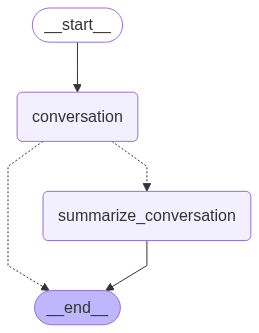

In [40]:
# ------------------------------------------------------ #
# COMPILE GRAPH
# ------------------------------------------------------ #
workflow = workflow_default()
graph = workflow.compile(checkpointer=memory)
# graph = workflow.compile()
# print(graph.get_graph().draw_ascii())
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": "1"}}
# Start conversation
chunks = []
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunks.append(chunk)
    # print(chunk)
    chunk['conversation']["messages"].pretty_print()
chunks

[{'conversation': {'messages': AIMessage(content='I think we\'ve established that you\'d like to introduce yourself every time. That\'s okay!\n\nInstead of introducing ourselves again, let\'s try something new. Since you said "hi!" and introduced yourself as "Lance", I\'m going to take a wild guess: how about we play a game or have some fun? What do you say?\n\n(By the way, if you want to actually talk about something or ask me a question, feel free to do so anytime!)', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-06-16T20:12:37.758678Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2928909416, 'load_duration': 28898750, 'prompt_eval_count': 614, 'prompt_eval_duration': 179602791, 'eval_count': 96, 'eval_duration': 2717518417, 'model_name': 'llama3.2:latest'}, id='run--c9dccb4d-5e4f-4edf-9358-077deb7bab79-0', usage_metadata={'input_tokens': 614, 'output_tokens': 96, 'total_tokens': 710})}},
 {'summarize_conversation': {'summary': "I

In [27]:
config = {"configurable": {"thread_id": "2"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
events = []
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    events.append(event)
    # print(chunk)
    print('vvv' * 25)
    for m in event['messages']:
        m.pretty_print()
    print('---' * 25)
events

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

I think I've got it now. Hi, Lance! It's clear you're having a bit of fun with our greeting exchange. Don't worry, I won't take offense. How about we mix things up and talk about something completely different? What do you say?
================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

I think I've got it now. Hi, Lance! It's clear you're having a bit of fun with our greeting 

[{'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='42a474b3-434c-40da-a2cd-1546128dfc8d'),
   AIMessage(content="I think I've got it now. Hi, Lance! It's clear you're having a bit of fun with our greeting exchange. Don't worry, I won't take offense. How about we mix things up and talk about something completely different? What do you say?", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-06-16T20:08:43.62104Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1761841208, 'load_duration': 29015083, 'prompt_eval_count': 179, 'prompt_eval_duration': 165336291, 'eval_count': 56, 'eval_duration': 1564702584, 'model_name': 'llama3.2:latest'}, id='run--2565d146-29f9-4f94-b66a-a8dc7198cd33-0', usage_metadata={'input_tokens': 179, 'output_tokens': 56, 'total_tokens': 235}),
   HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='77fb5276-d8a4-4ba6-874f-b9932a9bb0c8')

In [49]:
config = {'configurable': {'thread_id': '3'}}
input_message = HumanMessage(content='Tell me about the current conflicts that Israel is involved in.')
async for event in graph.astream_events({'messages': [input_message]}, config, version='v2'):
    # print('vvv')
    # print(f"Node: {event['metadata'].get('langgraph_node', '')}\n"
    #       f"Type: {event['event']}\n"
    #       f"Name: {event['name']}")
    # print('^^^')
    if event['event'] == 'on_chat_model_stream':
        data = event['data']
        print(data['chunk'].content, end='')


I'll provide an overview of some of the current conflicts that Israel is involved in:

**The Israeli-Palestinian Conflict**: This conflict has been ongoing for decades, with roots dating back to the early 20th century. It involves disputes over land, identity, and self-determination between Israelis and Palestinians.

* **Gaza Strip**: The Gaza Strip has been under Israeli occupation since 1967. The blockade, imposed in 2007, has led to widespread poverty, unemployment, and humanitarian crises.
* **West Bank**: Israel has occupied the West Bank since 1967, with settlements and military checkpoints creating significant obstacles to Palestinian movement and access to resources.

**Regional Conflicts**:

* **Hezbollah-Israel Conflict**: A proxy conflict between Israel and Hezbollah (a Lebanese Shia Islamist group) has been ongoing since the mid-2000s. The conflict is often characterized by rocket attacks from Lebanon into southern Israel.
* **Syrian Civil War**: During the Syrian civil wa